In [1]:
import os, sys, time, math, random, imageio
from datetime import datetime

### data science essen ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from pylab import *
from scipy import ndimage, misc
import seaborn as sns
from matplotlib import collections as matcoll
import textwrap
import matplotlib.dates as dates

### for streaming from google sheet ###
import gspread
from oauth2client.service_account import ServiceAccountCredentials

import multiprocessing
from multiprocessing import Pool

### set dots per square inch (dpi) for plots ###
mpl.rcParams['figure.dpi'] = 300

# Working with real data

In [2]:
### Stream directly from google sheet ###
'''
scope = ['https://spreadsheets.google.com/feeds']
credentials = ServiceAccountCredentials.from_json_keyfile_name('./hawaii-covid-timeline-48aab0d374b0.json', scope)
gc = gspread.authorize(credentials)
spreadsheet_key = #TODO: get your key
worksheet = book.worksheet("COVID Data")
table = worksheet.get_all_values()

##Convert table data into a dataframe
df = pd.DataFrame(table[1:], columns=table[0])

##Convert number strings to floats and ints
df = df.apply(pd.to_numeric, errors='ignore')
df.head()
'''

'\nscope = [\'https://spreadsheets.google.com/feeds\']\ncredentials = ServiceAccountCredentials.from_json_keyfile_name(\'./hawaii-covid-timeline-48aab0d374b0.json\', scope)\ngc = gspread.authorize(credentials)\nspreadsheet_key = #TODO: get your key\nworksheet = book.worksheet("COVID Data")\ntable = worksheet.get_all_values()\n\n##Convert table data into a dataframe\ndf = pd.DataFrame(table[1:], columns=table[0])\n\n##Convert number strings to floats and ints\ndf = df.apply(pd.to_numeric, errors=\'ignore\')\ndf.head()\n'

In [3]:
### Reade Hawaii Covid Data ###
### access and download at https://docs.google.com/spreadsheets/d/1z5U88_NVC84CB4kPyNbp5wy6liUyA2T9iPqmHfFpjr4/edit?usp=sharing
raw_data = pd.ExcelFile('Hawaii_Data_Collaborative_COVID_Dashboard_Data.xlsx')
print(raw_data.sheet_names)
df = raw_data.parse("COVID Data")
vax = raw_data.parse("DOH Vaccination Data")
hos = raw_data.parse("Hospital Data")

### Read in timeline data by Lambert Leong ###
### download at https://www.lambertleong.com/assets/docs/data/hawaii_covid_events_JAN22.csv'###
events=pd.read_csv('https://www.lambertleong.com/assets/docs/data/hawaii_covid_events_JAN22.csv')


['COVID Data', 'COVID Data Dictionary', 'COVID Data Notes', 'Test Positivity Rate', 'DOH Vaccination Data', 'Hospital Data', 'Hospital Data Dictionary', 'Cluster Reports', 'Data Sources']


Data from the state of Hawaii contains State totals as well as totals for all the islands.
We need to parse the data frame to include only state totals

## Cleaning case totals

In [4]:
### grab state totals ###
sdf=df[df['Region']=='State']

### State started filling out 'Confirmed Cases' col then switched to 'Total Cases' ###
### We need to merge them ###
full_cc=sdf[sdf['Confirmed Cases'].notnull()]
full_tc=sdf[sdf['Total Cases'].notnull()]
old_data=sdf[sdf['Date']<='2021-05-18']
new_data=sdf[sdf['Date']>'2021-05-18']

### merge ###
old_data['total_cases']=old_data['Confirmed Cases'].astype('float64')
new_data['total_cases']=new_data['Total Cases']
old_data['new_cases']=old_data['New Confirmed Cases'].astype('float64')
new_data['new_cases']=new_data['New Cases']

### merge data and drop any duplicate rows ###
clean=old_data.append(new_data)
clean.drop_duplicates(subset=None,keep = 'first', inplace = True)

### merge case data with vaccine data ###
clean_vax=pd.merge(clean, vax.iloc[:,:2], on='Date', how='left')
clean_vax=pd.merge(clean_vax, hos.iloc[:,:-1], on='Date', how='left')



/mnt/srl-oahu-1/disk/lambert/anaconda/envs/env_jun21/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/mnt/srl-oahu-1/disk/lambert/anaconda/envs/env_jun21/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/mnt/srl-oahu-1/disk/lambert/anaconda/envs/env_jun21/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [5]:
### Lets make a quick plotting function for the next few concepts ###
def quick_plot(test: pd.DataFrame, scale: float=1) -> None:
    ### Lets create fields we are interested in ###
    test['vax_rate']=test['Value']
    test['death_rate']=test['Deaths_Tot']/test['total_cases']*scale
    test['hospital_rate']=test['Active Hospitalized']/test['total_cases']*scale

    ### lets look at the data ###
    fig, ax = plt.subplots()
    #fig.set_size_inches(xsize, ysize)
    ax2 = ax.twinx()
    ### plot data by date ###
    dates, cases, deaths = test['Date'],test['total_cases'],test['death_rate']
    vax, hos = test['vax_rate'],test['hospital_rate']
    ax.plot_date(dates,cases, ls='-',marker='',color='darkorange',label='Total Cases')   
    ax2.plot_date(dates,vax, ls='-',marker='',color='g',label='Total Vaccination Rate')
    ax2.plot_date(dates,hos, ls='-',marker='',color='b',label='Hospitalization Rate')
    ax2.plot_date(dates,deaths, ls='-',marker='',color='r',label='Death Rate')
    ax.legend(loc=2)
    ax2.legend(loc=7)
    plt.close()

    return fig

In [6]:
test=clean_vax.copy(deep=True)
### lets fill nan values with zeros ###
test=test.fillna(0)


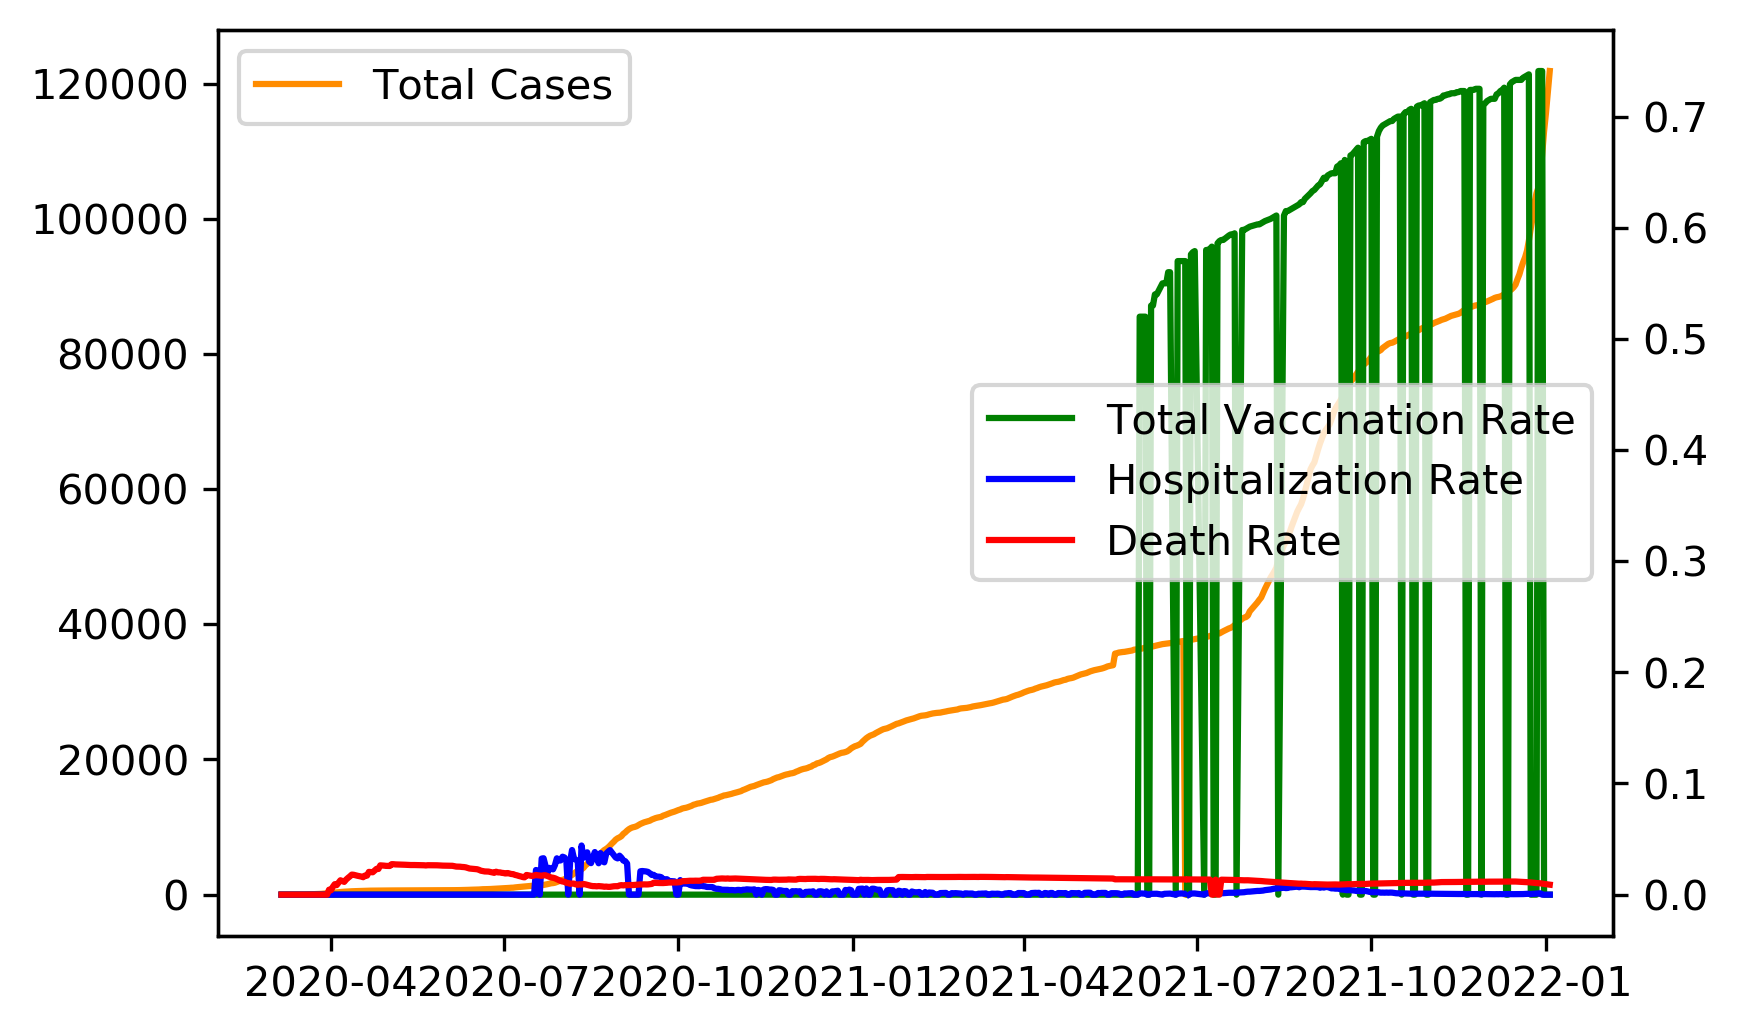

In [7]:
first_pass=quick_plot(test)
first_pass#.savefig('covid_caseVrate_init.png', dpi=300, bbox_inches='tight')

So we have two problems, missing data and the difference between scalse are different.
We originally filled the NaN values with zero so lets interpolate so that we can infer a 
more realistic curve.

## Fix missing data

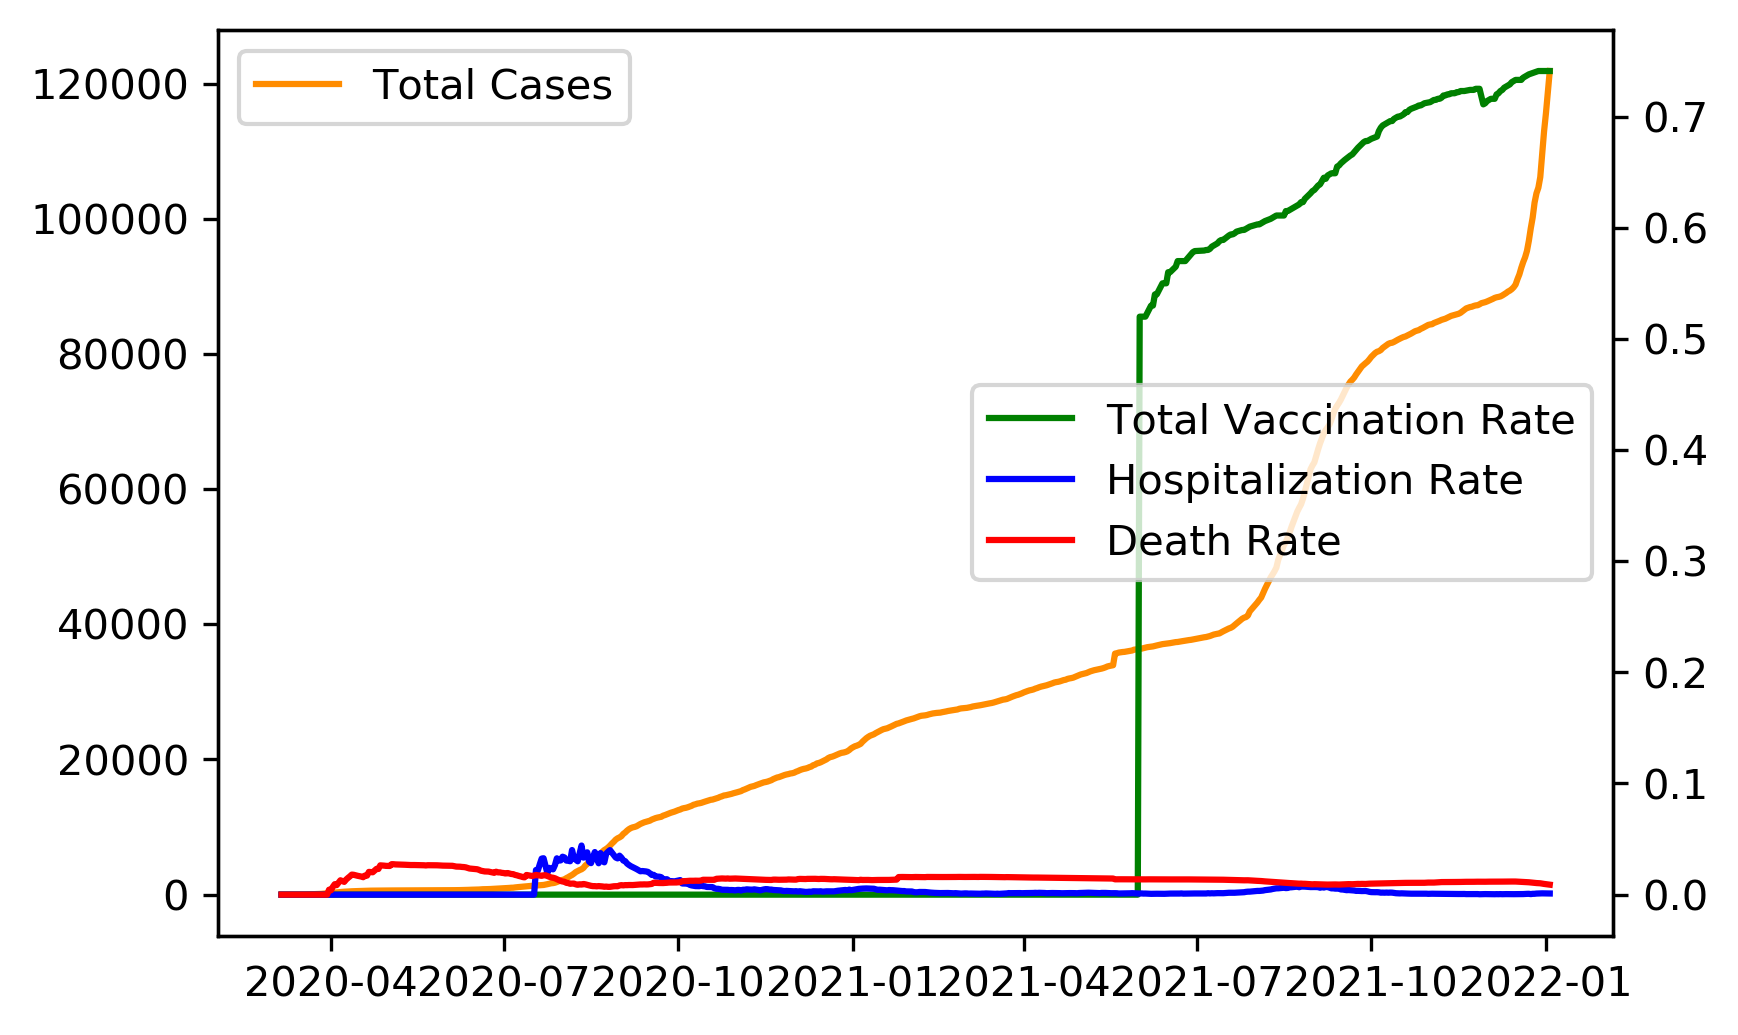

In [8]:
test=clean_vax.copy(deep=True)
### interpolate ###
test=test.interpolate()
test=test.fillna(0)
interopl=quick_plot(test)
interopl#.savefig('covid_caseVrate_init_interpol.png', dpi=300, bbox_inches='tight')

So we almost fixed the missing data problem but we still have these abrupt increases in
values shown by the vertical portion of the green line. We need to use the event and 
calendar events to better the interpolation.

/mnt/srl-oahu-1/disk/lambert/anaconda/envs/env_jun21/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


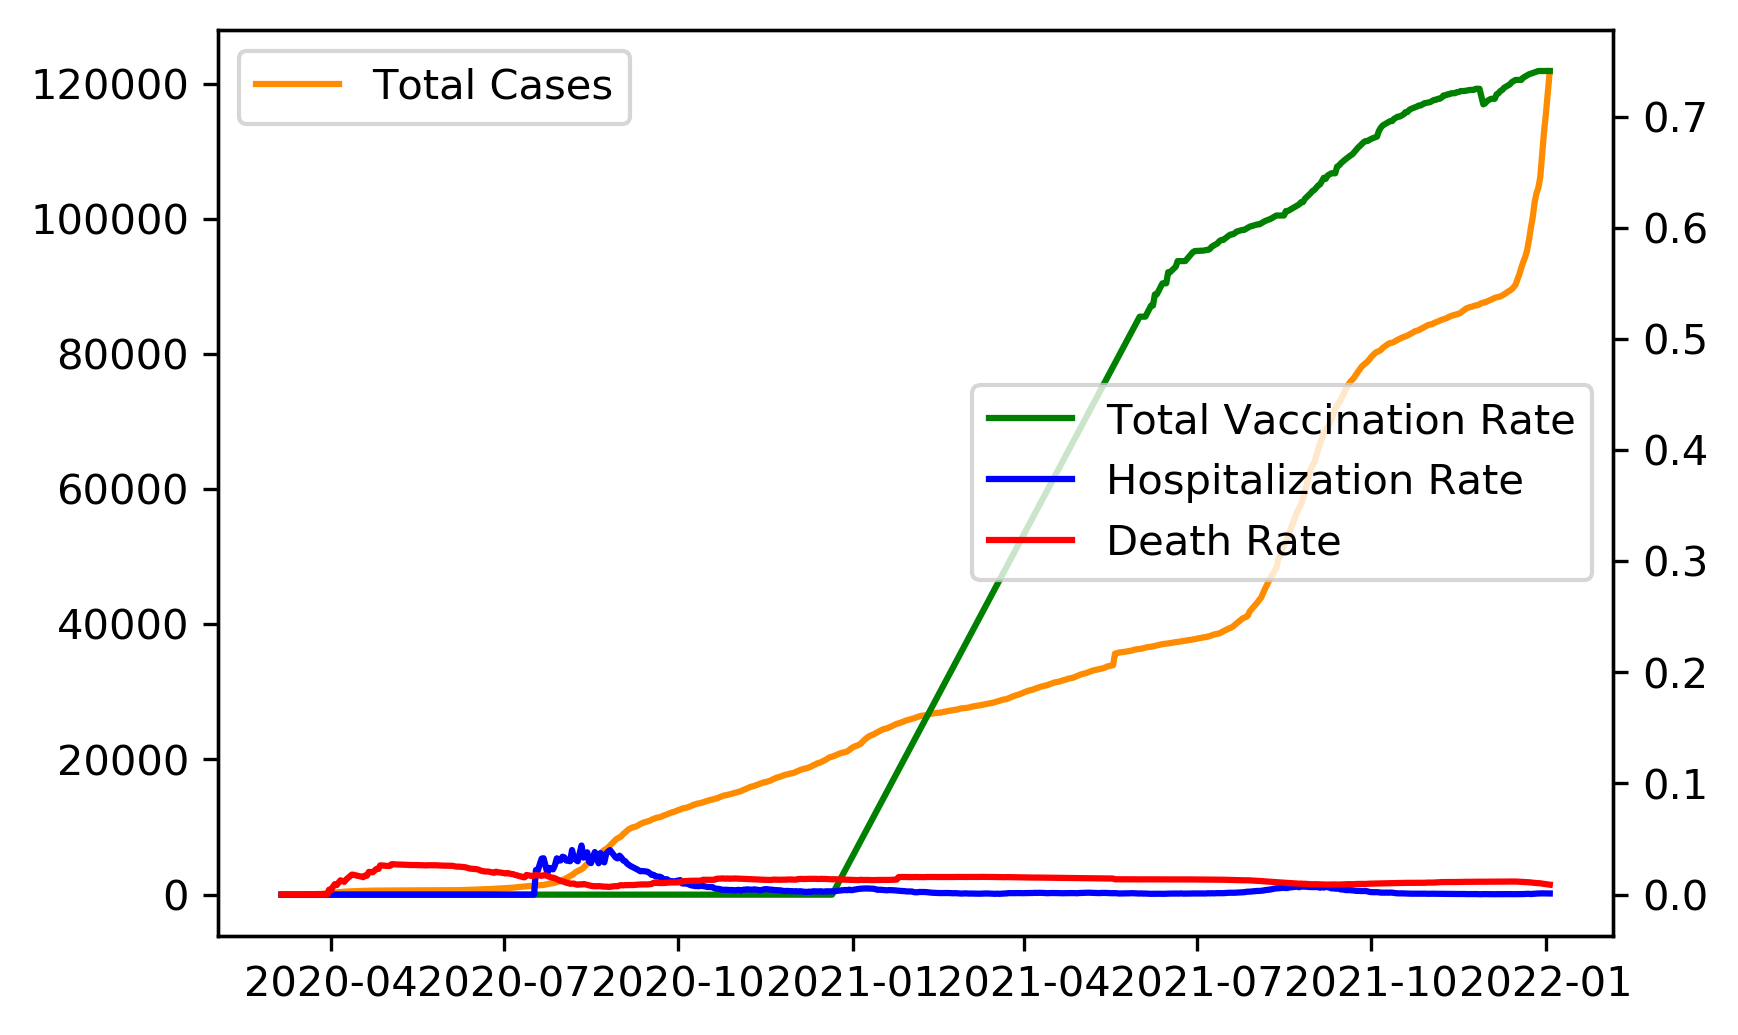

In [9]:
### find when the vaccines got to the islands and set that point to zero ###
start_vax=events[events['Event'].str.contains('vaccine')]['Date'].values[0]
test=clean_vax.copy(deep=True)
test['Value'][test[test.Date==start_vax].index[0]]=0
### interpolate ###
test=test.interpolate()
test=test.fillna(0)

fix_vax=quick_plot(test)
fix_vax#.savefig('covid_caseVrate_iterpol.png', dpi=300, bbox_inches='tight')

## Fix scale

Death and hospitalization rates are calculated by dividing by the total cases. We multiply
the rates by 10 so that it scalse better with the vaccination rate. Case totals are in the
hundred thosands so multiplying by 10 will result in a rate per 10K rather than 100K. Thus
making the scale better

/mnt/srl-oahu-1/disk/lambert/anaconda/envs/env_jun21/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


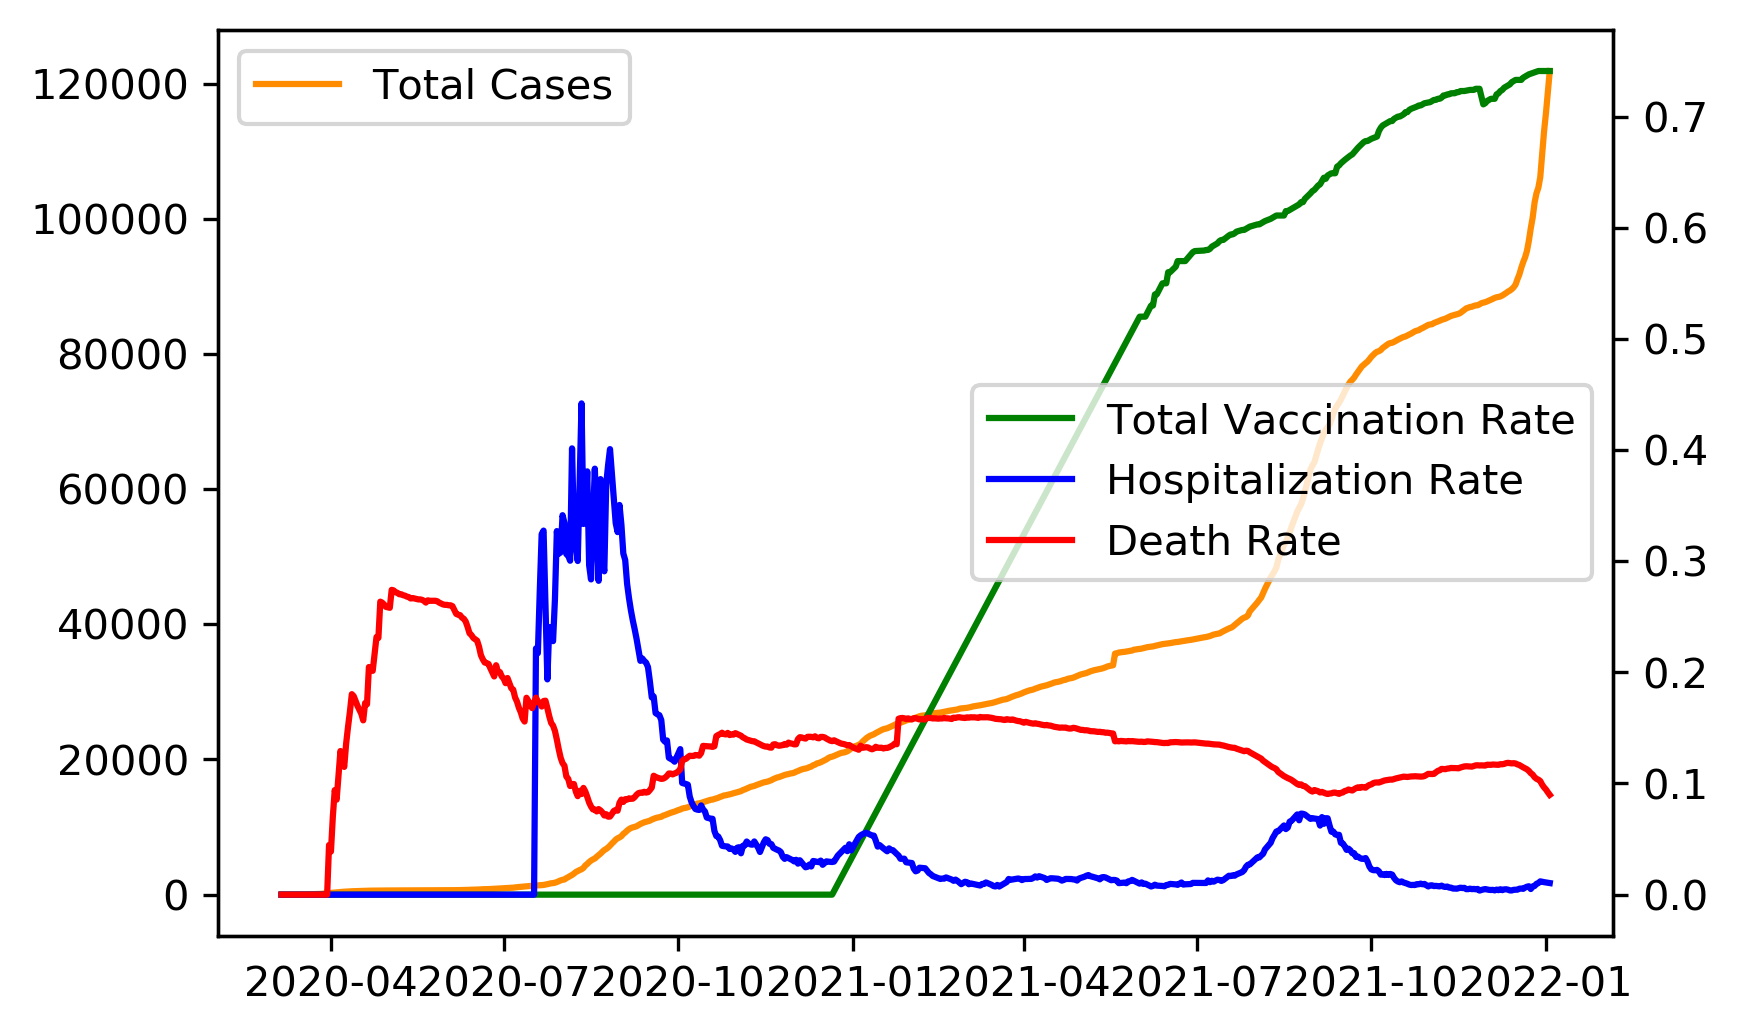

In [10]:
### find when the vaccines got to the islands and set that point to zero ###
start_vax=events[events['Event'].str.contains('vaccine')]['Date'].values[0]
test=clean_vax.copy(deep=True)
test['Value'][test[test.Date==start_vax].index[0]]=0
### interpolate ###
test=test.interpolate()
test=test.fillna(0)
 
fix_scale=quick_plot(test,10)
fix_scale#.savefig('covid_caseVrate_fixed.png', dpi=300, bbox_inches='tight')

# Merge with events and start making animated plots

In [11]:
### merge case data with vaccine data ###
clean_vax=pd.merge(clean, vax.iloc[:,:2], on='Date', how='left')
clean_vax=pd.merge(clean_vax, hos.iloc[:,:-1], on='Date', how='left')
'''
sigmoid curve is more realistic for vaccine rate but since there is not a good way to
model quickely, we settle for a quadratic interpolation.
'''
### find when the vaccines got to the islands and set that point to zero ###
start_vax=events[events['Event'].str.contains('vaccine')]['Date'].values[0]
clean_vax['Value'][clean_vax[clean_vax.Date==start_vax].index[0]]=0
### handleing trailing NaN ###
max_vax=clean_vax.Value.idxmax()
clean_vax.Value[max_vax:]=clean_vax.Value.max()
### interpolate ###
clean_vax=clean_vax.interpolate(method='quadratic',limit_direction='forward')
clean_vax=clean_vax.fillna(0)
### clean date strings for presentation ###
clean_vax.Date=clean_vax['Date'].dt.strftime('%-m/%-d/%y')
### merge with events ###
full=pd.merge(clean_vax,events, how='left', on='Date')

### create fields we want###
full['vax_rate']=full['Value']
full['death_rate']=full['Deaths_Tot']/full['total_cases']*10
full['hospital_rate']=full['Active Hospitalized']/full['total_cases']*10

full.death_rate.max(), full.total_cases.max()/10, full.hospital_rate.max()

/mnt/srl-oahu-1/disk/lambert/anaconda/envs/env_jun21/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/mnt/srl-oahu-1/disk/lambert/anaconda/envs/env_jun21/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


(0.27419354838709675, 12186.4, 0.44195953141640043)

In [12]:
def plot_2axis(dates: pd.Series,cases: pd.Series, deaths: pd.Series, vax: pd.Series, hos: pd.Series, ymax1:float=None,ymax2:float=None, xsize: float=7,ysize: float=5):
    fig, ax = plt.subplots()
    fig.set_size_inches(xsize, ysize)
    ax2 = ax.twinx()
    ### plot data by date ###
    ax.plot_date(dates,cases, ls='-',marker='',color='darkorange',label='Total Cases')   
    ax2.plot_date(dates,vax, ls='-',marker='',color='g',label='Total Vaccination Rate')
    ax2.plot_date(dates,hos, ls='-',marker='',color='b',label='Hospitalization Rate per 10K cases')
    ax2.plot_date(dates,deaths, ls='-',marker='',color='r',label='Death Rate per 10K cases')
    ### set axis limits ##
    if not ymax1:
        ymax1=cases.max()*1.1
    if not ymax2:
        ymax2=max([deaths.max(),vax.max(),hos.max()])*1.1 #1
    ax.set_ylim([0,ymax1])
    ax2.set_ylim([0.0,ymax2])
    
    ax.margins(x=0)
    ax.xaxis.set_major_locator(MultipleLocator(30))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ### date orientation and freq ###
    fig.autofmt_xdate(ha='center',rotation=90) #BTW, this is the slowest operation

    ### grid lines ###
    ax.grid(axis='y',color='darkorange', alpha=0.5)
    ax2.grid(axis='y')
    ax.grid(axis='x')
    ax.locator_params(axis="y", nbins=6)
    ax2.locator_params(axis="y", nbins=6)
    ### legend ###
    ax.legend(loc=2, title="Total Cases\n(left y-axis)", fontsize='small', fancybox=True)
    ax2.legend(loc=9, title="Rates\n(right y-axis)", fontsize='small', fancybox=True, framealpha=0.5)
    ### scoreboard ###
    ax.set_ylabel('Total Cases', fontsize='medium')
    ax2.set_ylabel('Rates', fontsize='medium')
    ax.set_xlabel('Date', fontsize='medium')
    ### title ###
    ax.set_title('Hawaii COVID-19 Cases and Rates')
    scoreboard= 'Total Cases (orange) = '+str(round(cases.values[-1],0))
    scoreboard+='\nDeath Rate (red) = '+str(round(deaths.values[-1],2))
    scoreboard+='\nHospitalization Rate (blue) = '+str(round(hos.values[-1],2))
    scoreboard+='\nVaccination Rate (green) = '+str(round(vax.values[-1],2))
    ax.text(0.3, 0.55, scoreboard, horizontalalignment='left', verticalalignment='center', 
             transform=ax.transAxes,fontsize='small')
    ax.text(0.1, 0.051, 'lambertleong.com',
             fontsize='large', color='gray',
             ha='left', va='bottom', alpha=0.5, transform=ax.transAxes)
    ax.text(0.65, 0.38, 'lambertleong.eth',
             fontsize='large', color='gray',
             ha='left', va='bottom', alpha=0.5, transform=ax.transAxes)
    plt.close()
    return fig

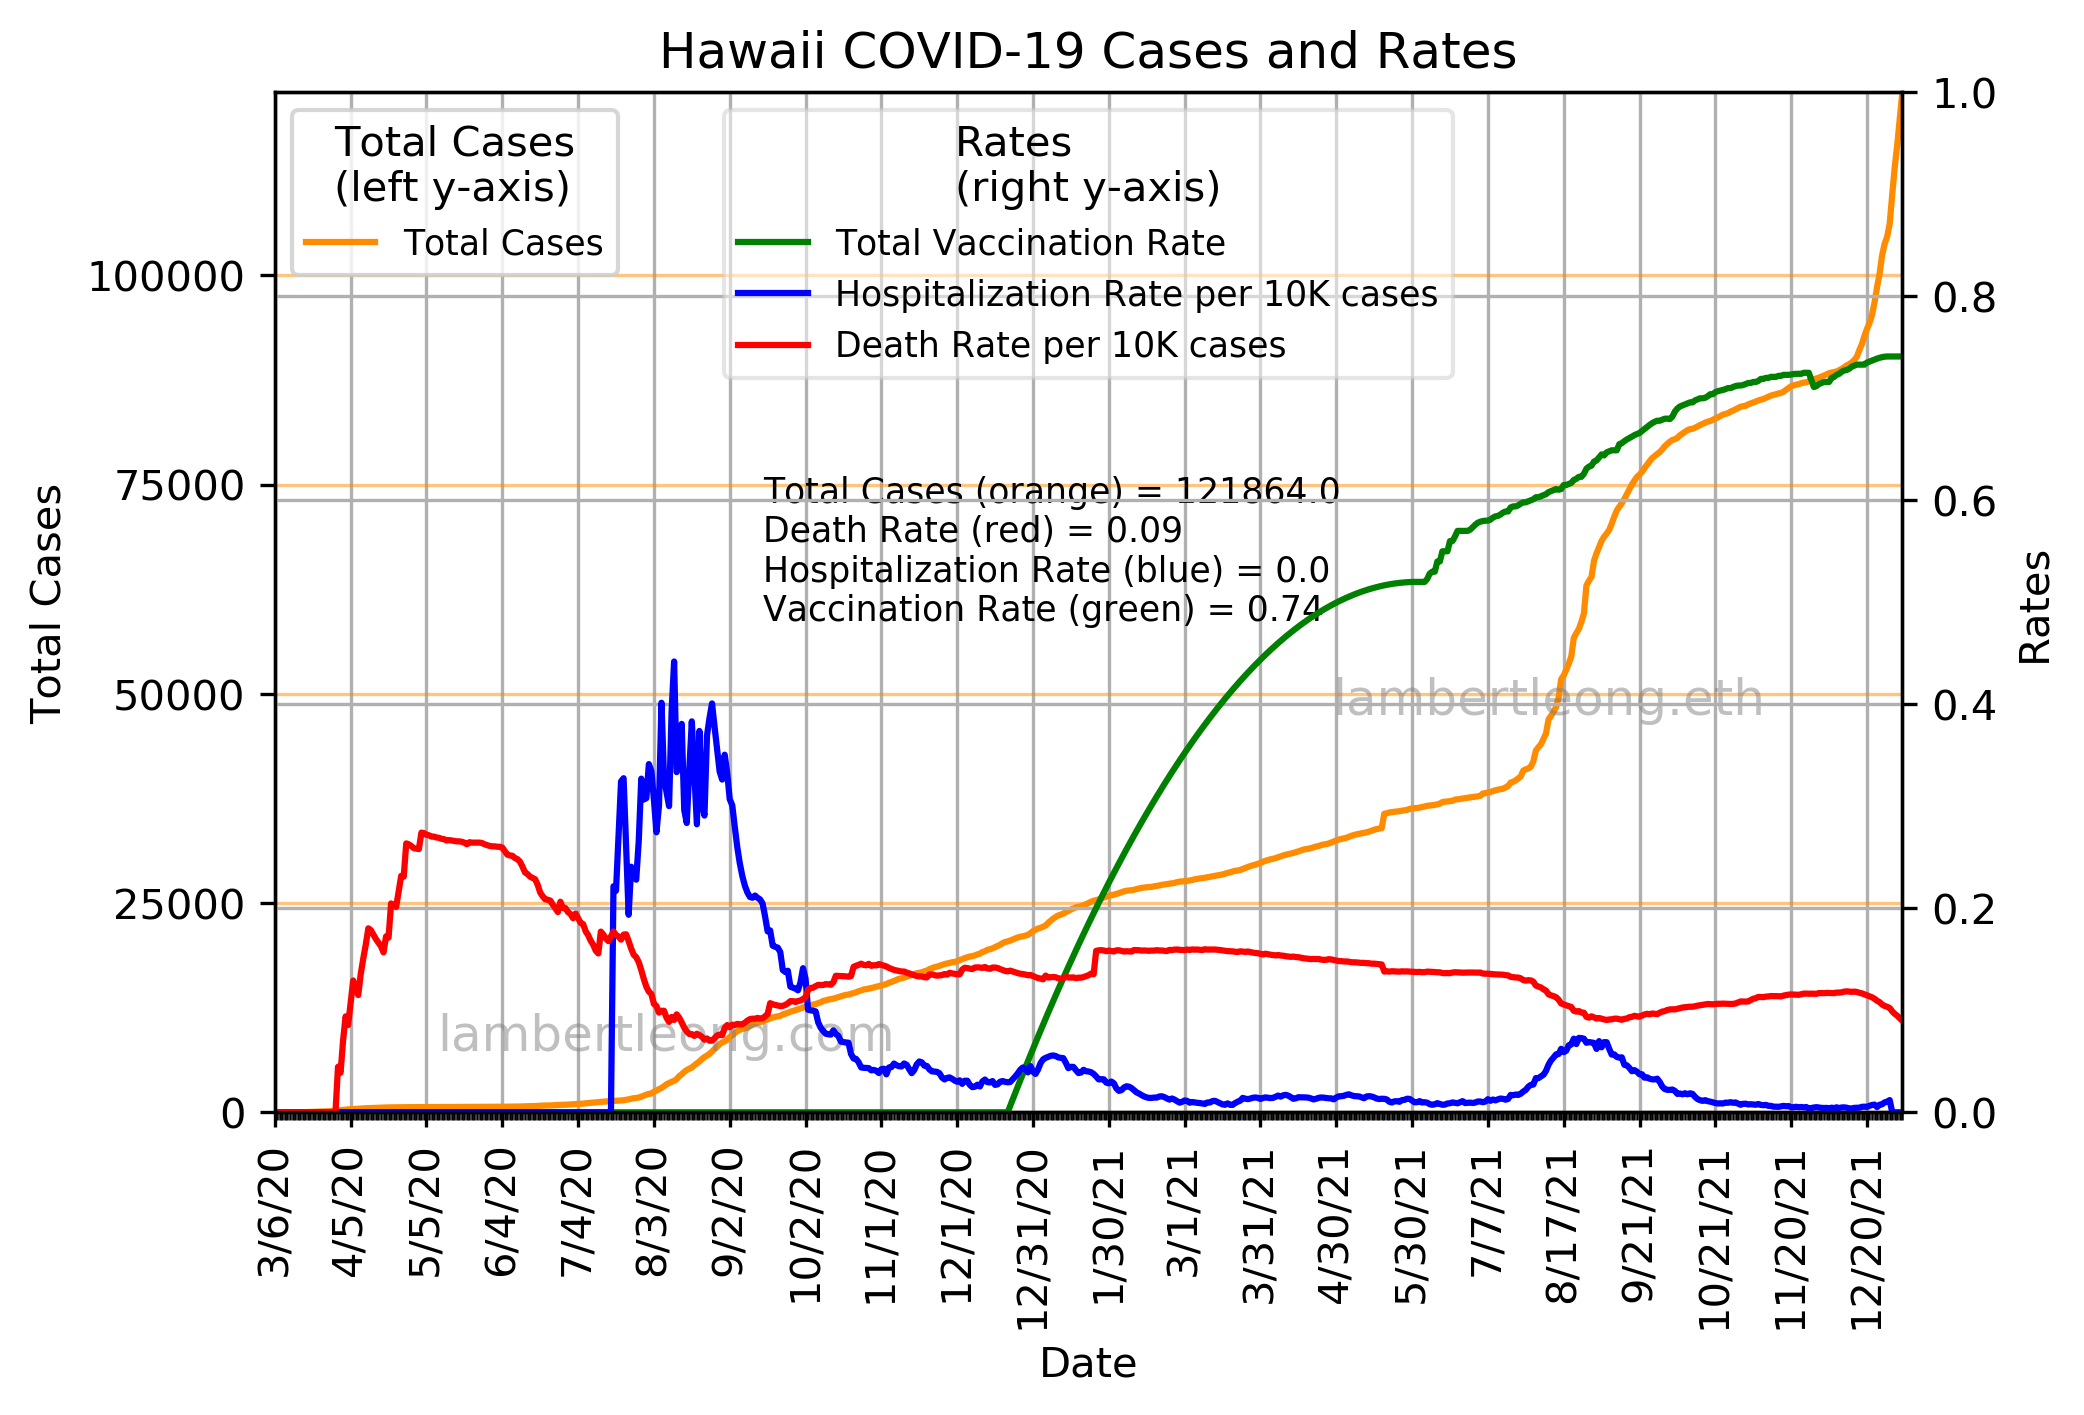

In [13]:
dates,t,d,v,h=full['Date'],full['total_cases'],full['death_rate'],full['vax_rate'],full['hospital_rate']
ymax1=full.total_cases.max()
ymax2=1
chart=plot_2axis(dates,t,d,v,h,ymax1=ymax1,ymax2=ymax2)
chart#.savefig('hawaii_covid_caseVrate.png', dpi=100, bbox_inches='tight')

In [14]:
### Build Animation for case vs rate ###
'''
writer = imageio.get_writer('static_2axis.mp4', fps=20)
max_y=full.total_cases.max()
ysize, xsize = 5.25,7

ymax1=full.total_cases.max()
ymax2=1
xmax=full.Date.values[-1]

start = time.time()
for i in range(1,full.shape[0]):
    #if i>365:
    #    break
    sub_df=full.iloc[:i]
    dates,t,d,v,h=sub_df['Date'],sub_df['total_cases'],sub_df['death_rate'],sub_df['vax_rate'],sub_df['hospital_rate']
    chart=plot_2axis(dates,t,d,v,h,xsize=xsize,ysize=ysize, ymax1=ymax1,ymax2=ymax2)

    dpi=int(chart.dpi)
    chart.canvas.draw()
    image = np.frombuffer(chart.canvas.tostring_rgb(), dtype='uint8').reshape(int(ysize*dpi),int(xsize*dpi), 3)
    #print('\t\tto image')
    writer.append_data(image)
    print('processed =',i,' of ',full.shape[0],end='\r')

writer.close()
end = time.time()
print('2 axis build time =',end - start)
'''

"\nwriter = imageio.get_writer('static_2axis.mp4', fps=20)\nmax_y=full.total_cases.max()\nysize, xsize = 5.25,7\n\nymax1=full.total_cases.max()\nymax2=1\nxmax=full.Date.values[-1]\n\nstart = time.time()\nfor i in range(1,full.shape[0]):\n    #if i>365:\n    #    break\n    sub_df=full.iloc[:i]\n    dates,t,d,v,h=sub_df['Date'],sub_df['total_cases'],sub_df['death_rate'],sub_df['vax_rate'],sub_df['hospital_rate']\n    chart=plot_2axis(dates,t,d,v,h,xsize=xsize,ysize=ysize, ymax1=ymax1,ymax2=ymax2)\n\n    dpi=int(chart.dpi)\n    chart.canvas.draw()\n    image = np.frombuffer(chart.canvas.tostring_rgb(), dtype='uint8').reshape(int(ysize*dpi),int(xsize*dpi), 3)\n    #print('\t\tto image')\n    writer.append_data(image)\n    print('processed =',i,' of ',full.shape[0],end='\r')\n\nwriter.close()\nend = time.time()\nprint('2 axis build time =',end - start)\n"

In [15]:
def build_covid_timeline_plot(data_df: pd.DataFrame, data_field: str, title:str, xsize:float=15 ,ysize:float=10,video:bool=False,
                              plt_color:str='blue'):#
    ''' creates a timeline plot which contains a line plot with date on the x axis and some eval metric on the y

        args:
            data_df (pd dataframe): dataframe containing atleast a date field and eval metric field
            (stored cummulatively) and "Events" field
            data_field (str): field to be plotted on the y axis
            xsize (int): plot width in inches, default = 15
            ysize (int): plot height in inches, default = 9
            plt_color (str): color of the line on the plot
            video (str): path to dir that stores video frames
    '''
    #define plot dimensions
    fig, ax = plt.subplots()
    fig.set_size_inches(xsize, ysize)
    ymax=int(data_df.loc[data_df[data_field].idxmax()][data_field])+20
    ymin=-(ymax// 1.5)
    ytot=ymax+(-1*ymin)
    #plotting
    ax.plot_date(data_df['Date'],data_df[data_field], ls='-',marker='',color=plt_color)
    ax.set_ylim([ymin,ymax])
    ax.axhline(y=0,color='black')#, xmin)
    #event plotting
    last_event=''
    rot=0
    color=None
    event_count=0
    large_list=0
    for i, row in data_df.iterrows():
        e_type=row['Type']
        if pd.isnull(e_type):
            continue
        e_type=str(e_type)
        if 'open' in e_type:
            color='green'
        elif 'close' in e_type:
            color='red'
        elif 'yield' in e_type:
            color='darkorange'
        elif 'event' in e_type:
            color='black'
        offset=1-(event_count%5*.18)-0.05 #.98 to pull off bottom axis
        event_count+=1
        bottom_y=(-1*ymin*offset)/ytot
        top_y=(int(row[data_field])+(-1*ymin))/ytot
        my_wrap = textwrap.TextWrapper(width = 15)
        #print(row)
        event_list = my_wrap.wrap(text=row['Event'])
        event_list=('\n').join(event_list)
        ax.axvline(row['Date'],ymin=ymin,ymax=top_y,c=color,label=e_type)
        ax.text(row['Date'],offset*ymin,event_list,rotation=rot, fontsize='x-small', ha='center',va='bottom', wrap=False,
                bbox=dict(boxstyle='square', fc='w', ec=color)#,alpha=.7)
               )
        last_event=event_list
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(8)
    ax.margins(x=0)
    ax.xaxis.set_major_locator(MultipleLocator(30))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    fig.autofmt_xdate(ha='center',rotation=90)
    yticks = ax.yaxis.get_major_ticks()
    for i in range(1,len(yticks)//2-1):
        yticks[i].set_visible(False)
    tick_params(axis='x', which='major', labelsize=8)
    ax.grid(axis='x')
    ax.grid(axis='y')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_title('Calendar Events and Hawaii COVID-19 \n'+title+' = '+
                 str(int(data_df.iloc[-1][data_field]))+' as of '+data_df.iloc[-1]['Date'], fontsize='xx-large')
    ax.set_ylabel('Number of '+title+' Cases', fontsize='medium')
    ax.set_xlabel('Date', fontsize='medium')
    handles, labels = ax.get_legend_handles_labels()
    handout=[]
    lablout=[]
    #rename legend
    for h,l in zip(handles,labels):
        if l == 'yield':
            l='warning'
        if l not in lablout:
            lablout.append(l)
            handout.append(h)
    ax.legend(handout, lablout,loc=7, title="Type of Event", fontsize='small', fancybox=True)
    ax.text(10, ytot*.0, 'lambertleong.com',
             fontsize='xx-large', color='gray',
             ha='left', va='bottom', alpha=0.5)
    #fig.tight_layout()
    ax.text(data_df['Date'].values[-1],data_df[data_field].values[-1], str(int(data_df[data_field].values[-1])),
             fontsize='large', color='black',
             ha='right', va='center', alpha=1.0)
    if video:
        ax.text(0.08,0.88,last_event,rotation=rot, fontsize='xx-large', ha='left', va='top', wrap=False,
        bbox=dict(boxstyle='square', fc='w', ec=color), transform=ax.transAxes)
    plt.close()
    return fig



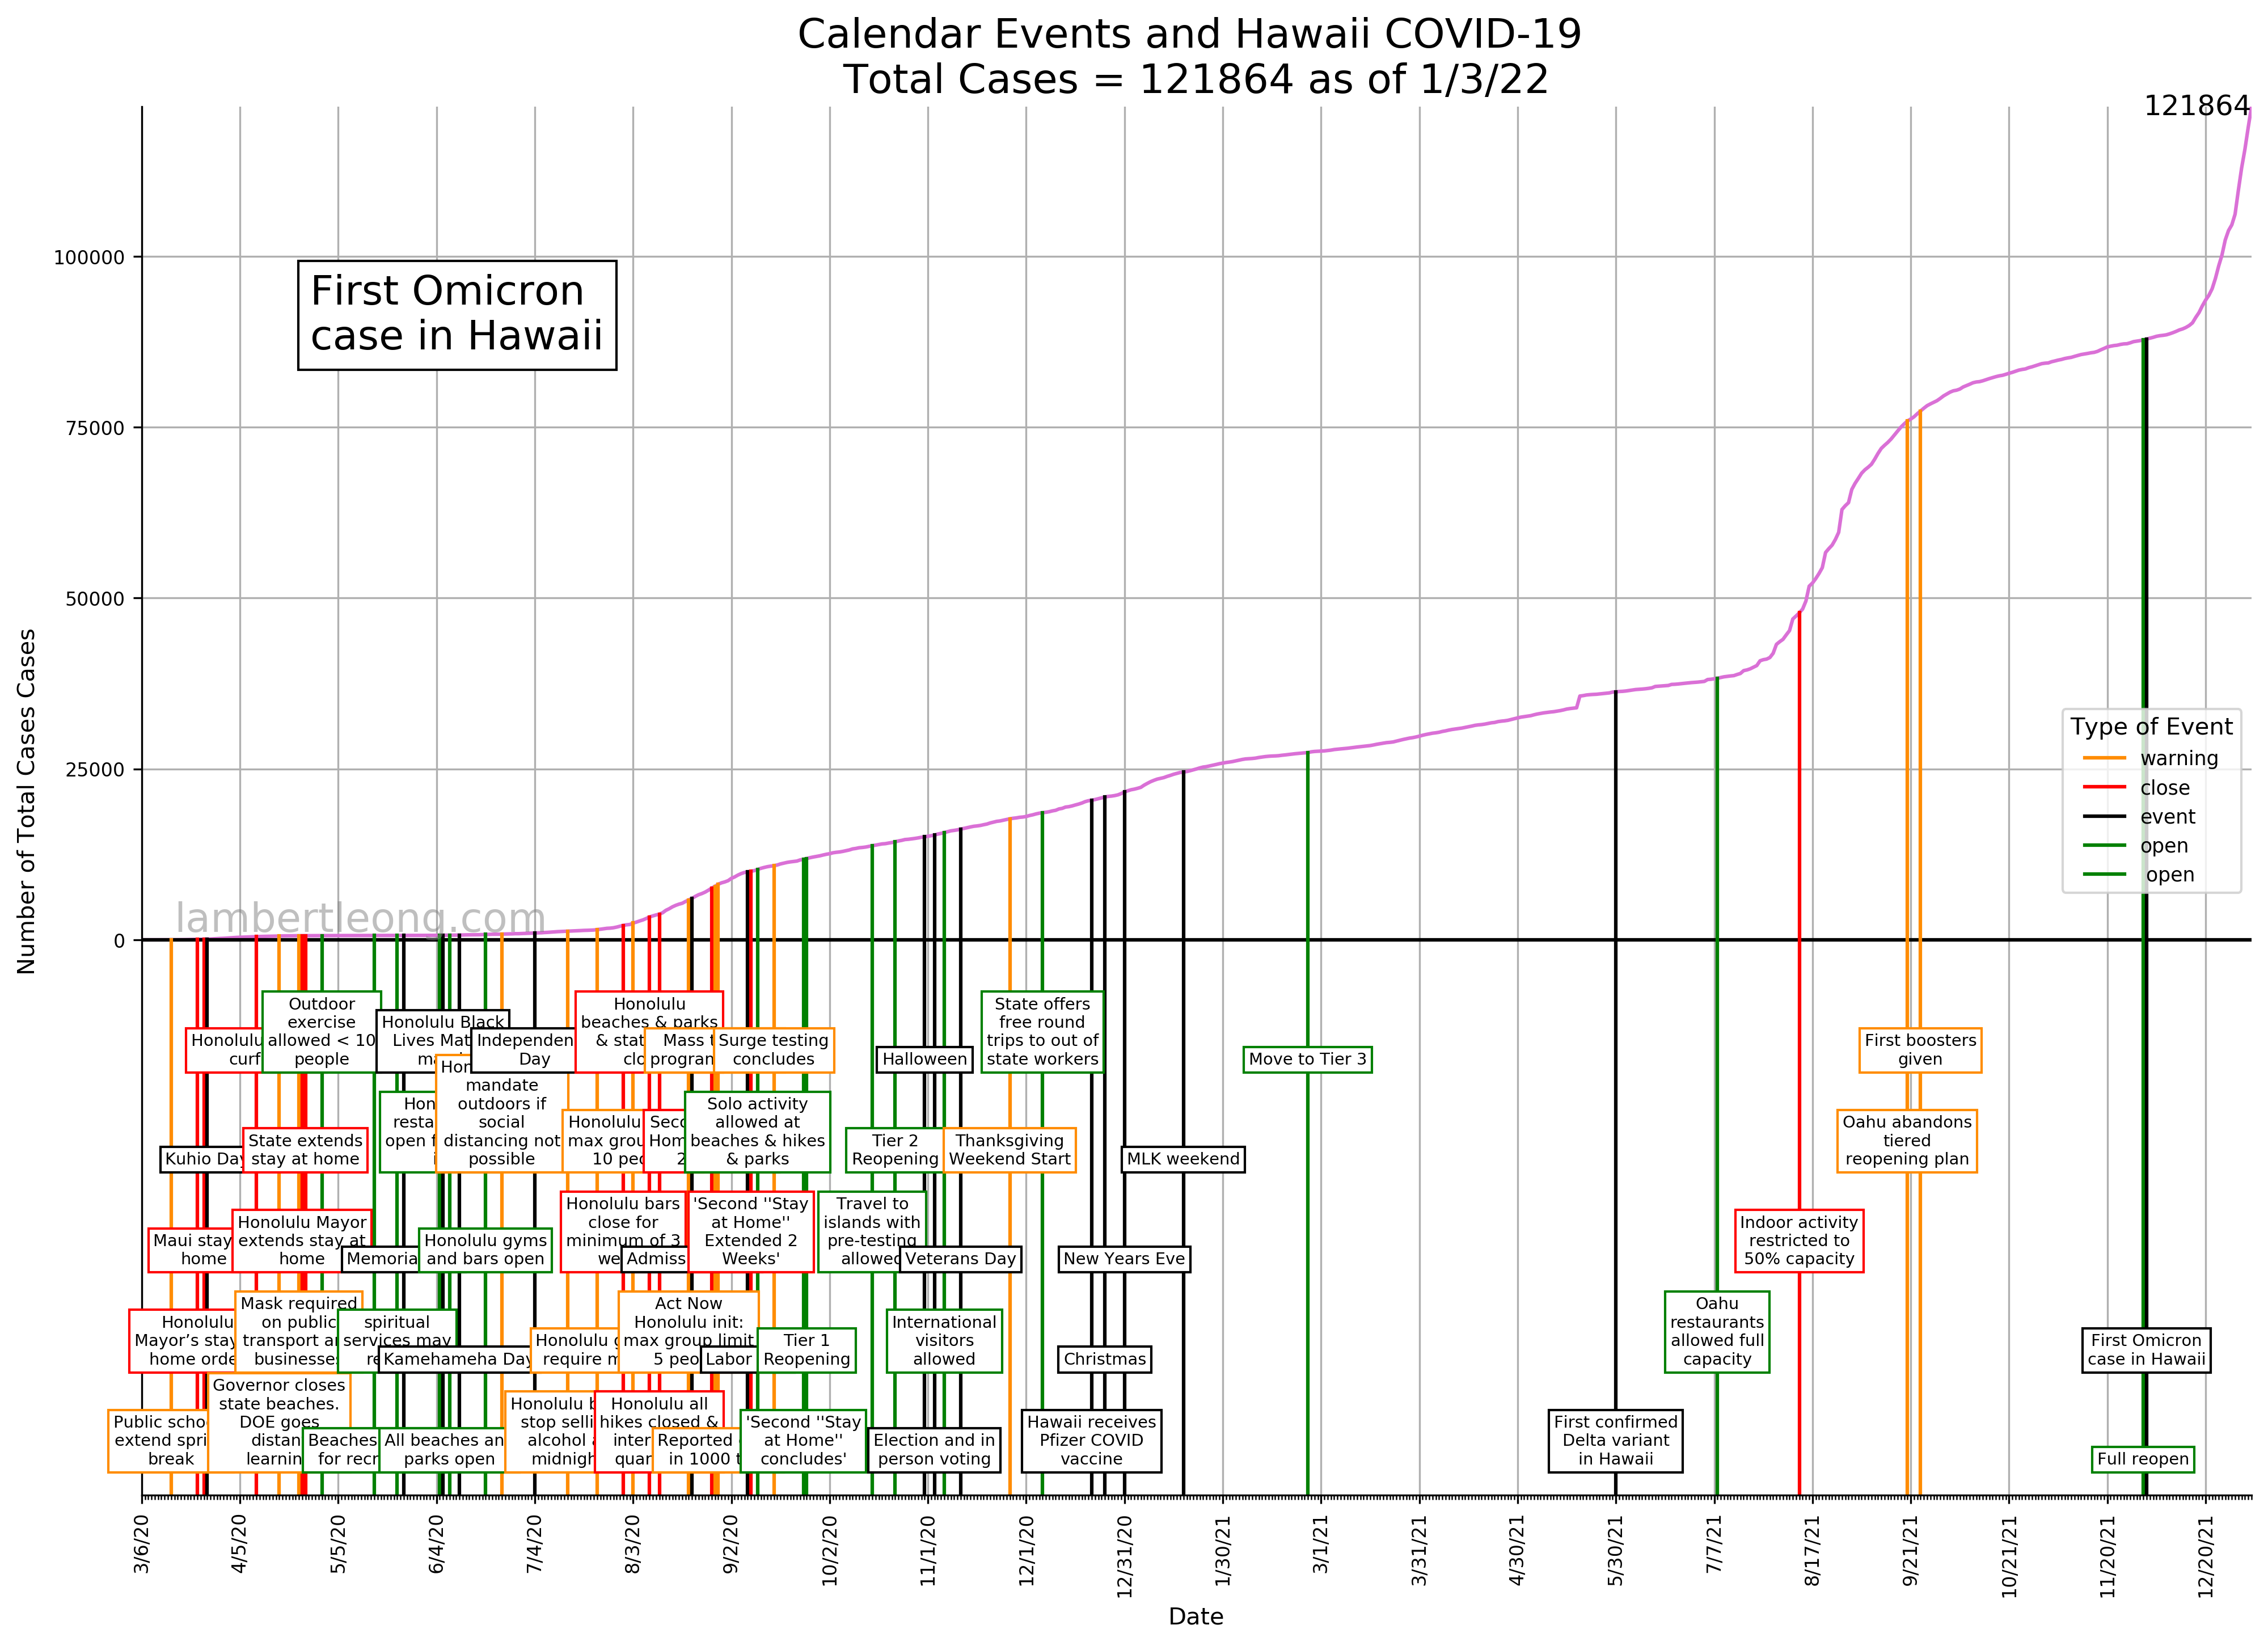

In [16]:
xsize=16
ysize=12
chart=build_covid_timeline_plot(full, 'total_cases','Total Cases', xsize=xsize ,ysize=ysize,
                                plt_color='orchid',video=True)#, save='test', video=None)
chart#.savefig('totalcasesVevents.png', dpi=300, bbox_inches='tight')

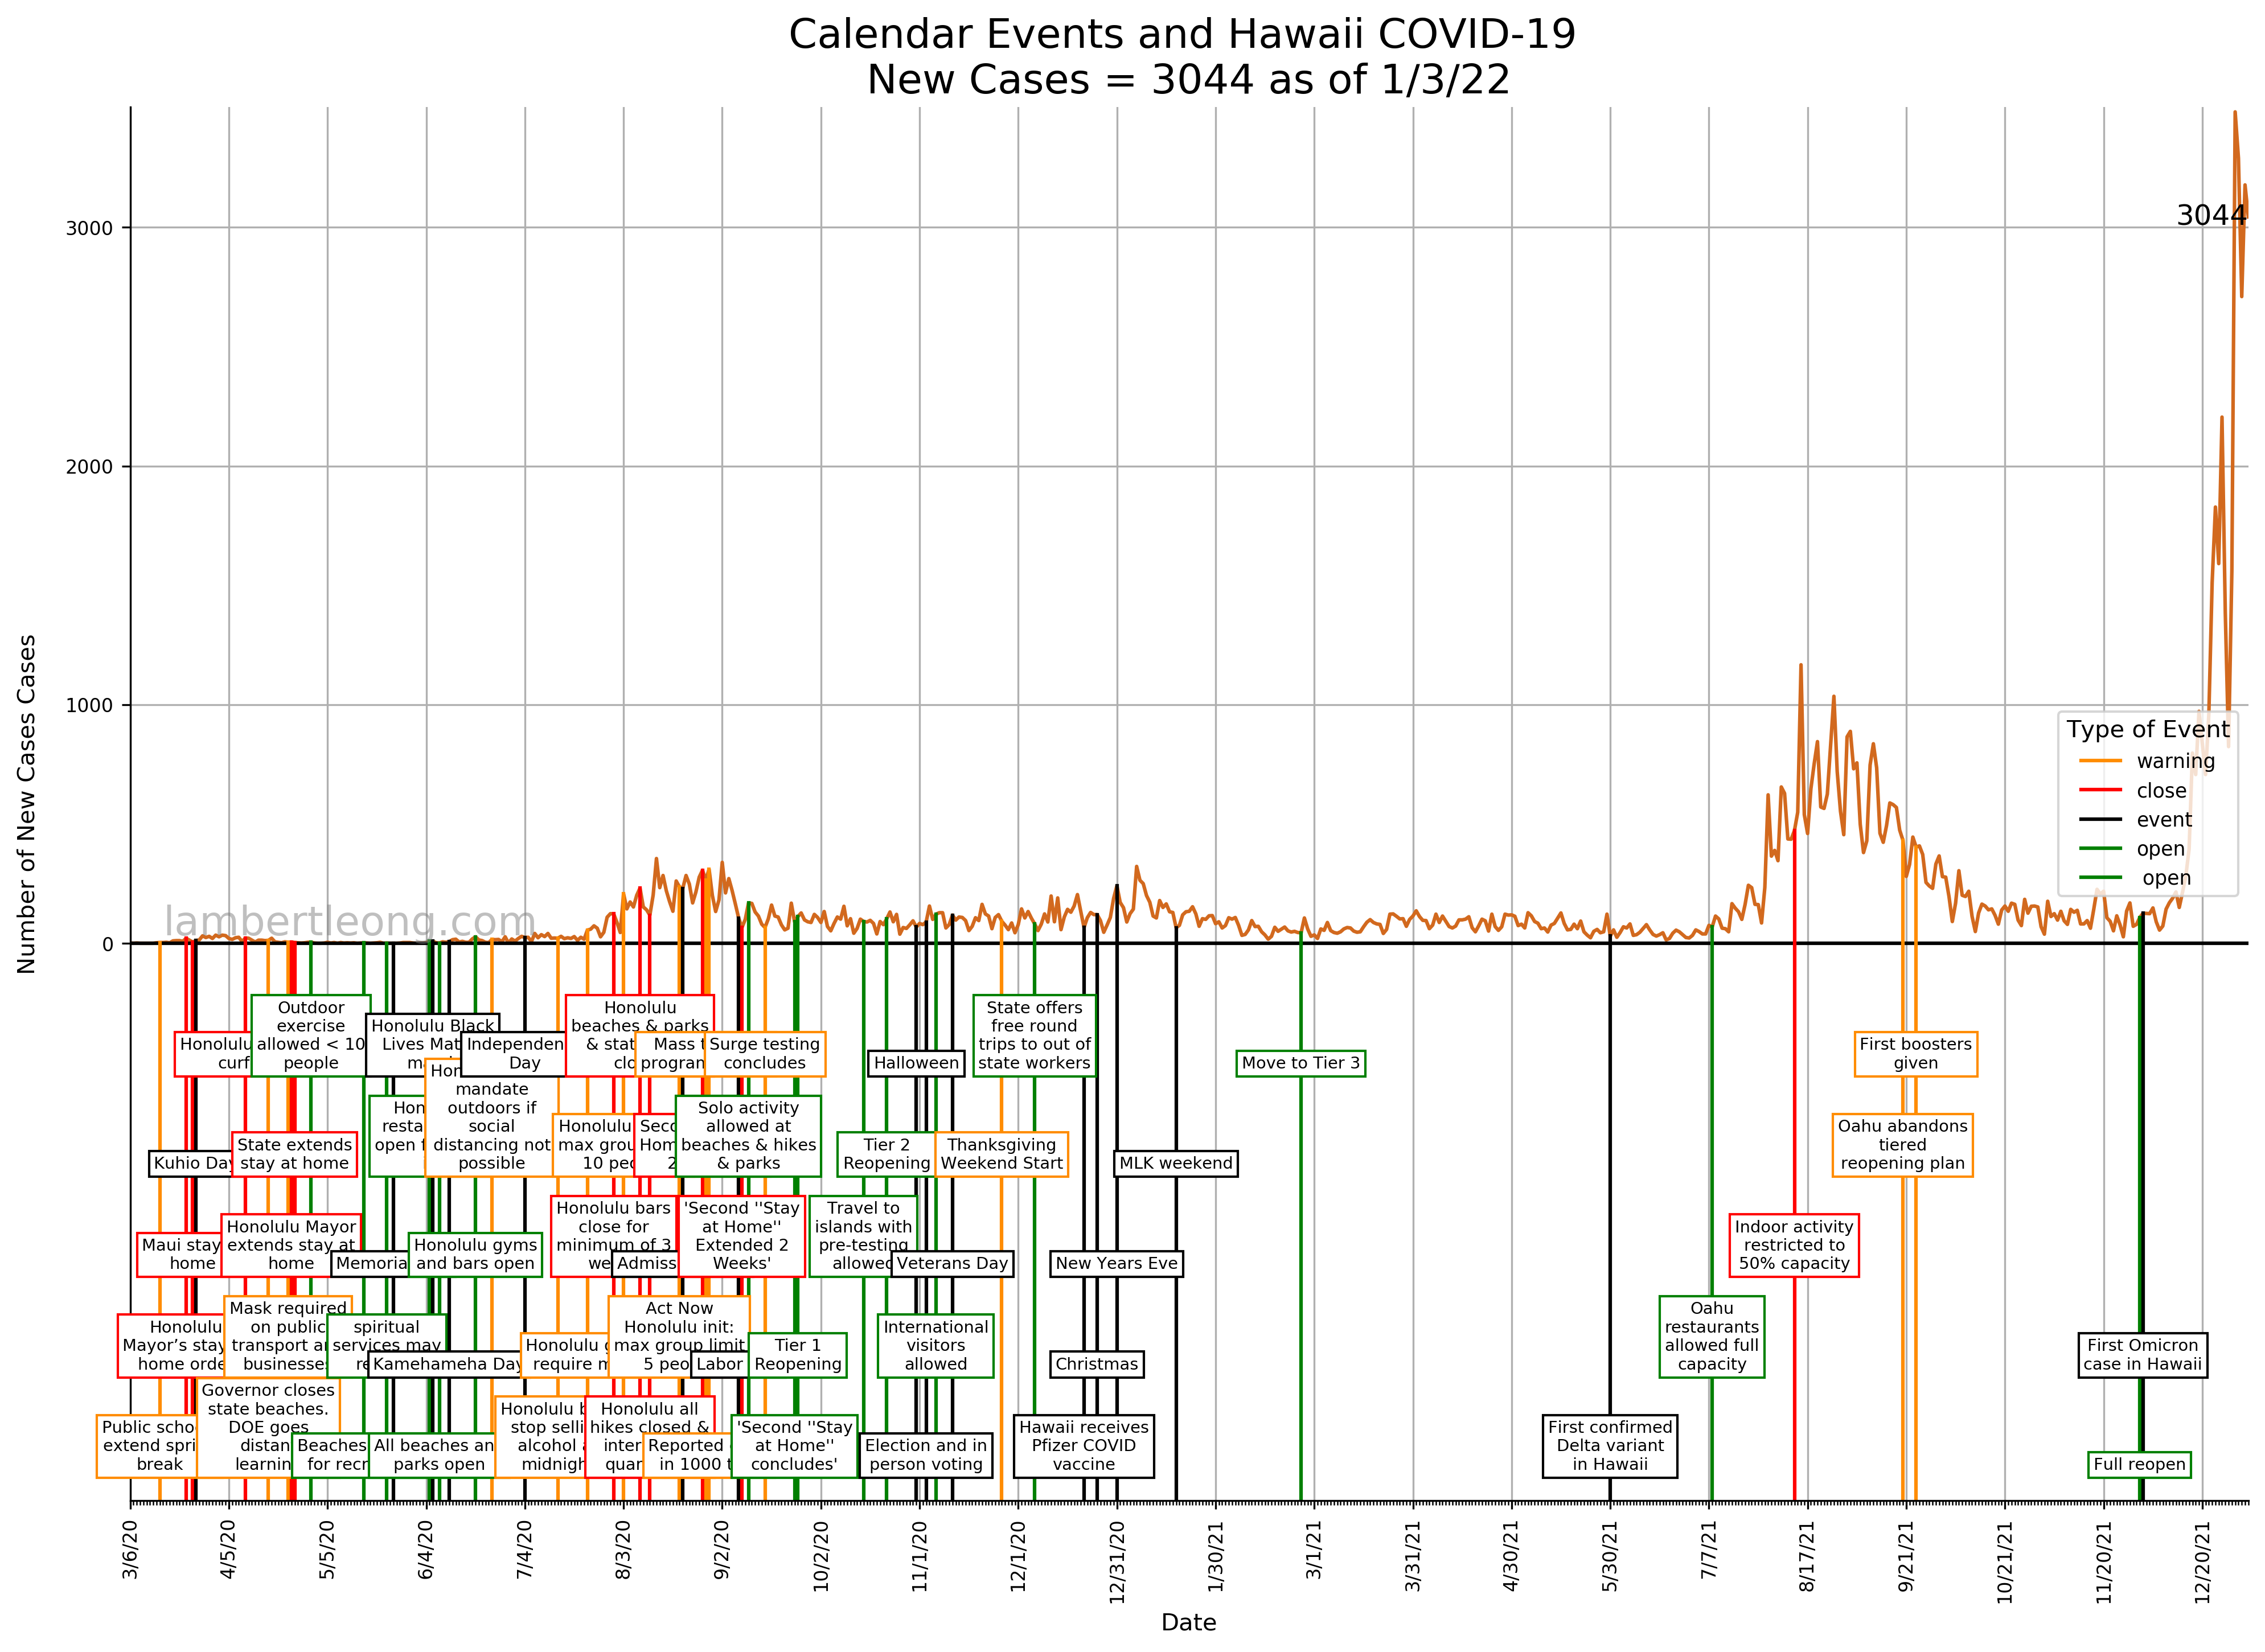

In [17]:
chart=build_covid_timeline_plot(full, 'new_cases','New Cases', xsize=xsize ,ysize=ysize,
                                plt_color='chocolate')
chart#.savefig('newcasesVevents.png', dpi=300, bbox_inches='tight')

In [18]:
### Build Animation ###
'''
start = time.time()
writer = imageio.get_writer('case_events2.mp4', fps=15)
writer2 = imageio.get_writer('new_case_events2.mp4', fps=15)
for i in range(1,full.shape[0]):
    #if i>365:
    #    break
    sub_df=full.iloc[:i]
    chart=build_covid_timeline_plot(sub_df, 'total_cases','Total Cases', xsize=xsize ,ysize=ysize,
                                plt_color='orchid',video=True)
    dpi=int(chart.dpi)
    chart.canvas.draw()
    image = np.frombuffer(chart.canvas.tostring_rgb(), dtype='uint8').reshape(ysize*dpi, xsize*dpi, 3)
    #print('\t\tto image')
    writer.append_data(image)
    ### writer2 below ###
    chart2=build_covid_timeline_plot(sub_df, 'new_cases','New Cases', xsize=xsize ,ysize=ysize,
                                plt_color='chocolate',video=True)
    dpi=int(chart2.dpi)
    chart2.canvas.draw()
    image2 = np.frombuffer(chart2.canvas.tostring_rgb(), dtype='uint8').reshape(ysize*dpi, xsize*dpi, 3)
    writer2.append_data(image2)
    print('processed =',i,end='\r')
writer.close()
writer2.close()
end = time.time()
print('event plot build time =',end - start)
'''

"\nstart = time.time()\nwriter = imageio.get_writer('case_events2.mp4', fps=15)\nwriter2 = imageio.get_writer('new_case_events2.mp4', fps=15)\nfor i in range(1,full.shape[0]):\n    #if i>365:\n    #    break\n    sub_df=full.iloc[:i]\n    chart=build_covid_timeline_plot(sub_df, 'total_cases','Total Cases', xsize=xsize ,ysize=ysize,\n                                plt_color='orchid',video=True)\n    dpi=int(chart.dpi)\n    chart.canvas.draw()\n    image = np.frombuffer(chart.canvas.tostring_rgb(), dtype='uint8').reshape(ysize*dpi, xsize*dpi, 3)\n    #print('\t\tto image')\n    writer.append_data(image)\n    ### writer2 below ###\n    chart2=build_covid_timeline_plot(sub_df, 'new_cases','New Cases', xsize=xsize ,ysize=ysize,\n                                plt_color='chocolate',video=True)\n    dpi=int(chart2.dpi)\n    chart2.canvas.draw()\n    image2 = np.frombuffer(chart2.canvas.tostring_rgb(), dtype='uint8').reshape(ysize*dpi, xsize*dpi, 3)\n    writer2.append_data(image2)\n    prin

# NY Times Data

In [19]:
ny_df=pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')#('https://healthdata.gov/resource/g62h-syeh.csv')

hi=ny_df[ny_df['state']=='Hawaii']

d2=hi.copy(deep=True)
d2.date=pd.to_datetime(d2['date'])
d2['Date']=d2['date'].dt.strftime('%-m/%-d/%y')
variants=events.loc[(events.Event.str.contains('Delta')) | (events.Event.str.contains('Omicron'))]
d3=pd.merge(d2,variants, how='left', on='Date')
d3['death_rate']=d3.deaths/d3.cases

In [20]:
def plot_caseVdeath(df: pd.DataFrame, ymax1: float=None,ymax2: float=None, xsize: float=7,ysize: float=5):
    fig, ax = plt.subplots()
    fig.set_size_inches(xsize, ysize)
    ax2 = ax.twinx()
    ### plot data by date ###
    ax.plot_date(df.Date,df.cases, ls='-',marker='',color='darkorange',label='Total Cases')   
    ax2.plot_date(df.Date,df.death_rate, ls='-',marker='',color='r',label='Death Rate')
    ### set axis limits ##
    if not ymax1:
        ymax1=df.cases.max()*1.1
    if not ymax2:
        ymax2=max([df.death_rate.max()])*1.1 #1
    ax.set_ylim([0,ymax1])
    ax2.set_ylim([0.0,ymax2])
    ### axis color ###
    ax.yaxis.label.set_color('darkorange')
    ax2.yaxis.label.set_color('red')
    ax.margins(x=0)
    ax.xaxis.set_major_locator(MultipleLocator(30))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ### date orientation and freq ###
    fig.autofmt_xdate(ha='center',rotation=90) #BTW, this is the slowest operation

    ### grid lines ###
    ax.grid(axis='y',color='darkorange', alpha=0.5)
    ax2.grid(axis='y')
    ax.grid(axis='x')
    ax.locator_params(axis="y", nbins=6)
    ax2.locator_params(axis="y", nbins=6)
    ### legend ###
    ax.legend(loc=2, title="Total Cases\n(left y-axis)", fontsize='small', fancybox=True)
    ax2.legend(loc=9, title="Rates\n(right y-axis)", fontsize='small', fancybox=True, framealpha=0.5)
    ### scoreboard ###
    ax.set_ylabel('Total Cases', fontsize='medium')
    ax2.set_ylabel('Rates', fontsize='medium')
    ax.set_xlabel('Date', fontsize='medium')
    ### title ###
    ax.set_title('Hawaii COVID-19 Cases and Rates')
    scoreboard= 'Total Cases (orange) = '+str(round(df.cases.values[-1],0))
    scoreboard+='\nDeath Rate (red) = '+str(round(df.death_rate.values[-1],2))
    #event plotting
    last_event=''
    rot=0
    color=None
    event_count=0
    large_list=0
    for i, row in df.iterrows():
        e_type=row['Type']
        if pd.isnull(e_type):
            continue
        e_type=str(e_type)
        if event_count==0:
            texty=0.25*ymax1
        else:
            texty=0.75*ymax1
        color='black'
        event_count+=1
        my_wrap = textwrap.TextWrapper(width = 15)
        event_list = my_wrap.wrap(text=row['Event'])
        event_list=('\n').join(event_list)
        ax.axvline(row['Date'],ymin=0,ymax=ymax1,c=color,label=e_type)
        ax.text(row['Date'], texty,event_list,rotation=rot, fontsize='x-small', ha='center',
                va='bottom', wrap=False, bbox=dict(boxstyle='square', fc='w', ec=color))#,transform=ax.transAxes)#,alpha=.7))
        last_event=event_list
    
    ax.text(0.3, 0.60, scoreboard, horizontalalignment='left', verticalalignment='center', 
             transform=ax.transAxes,fontsize='small')
    ax.text(0.1, 0.051, 'lambertleong.com',
             fontsize='large', color='gray',
             ha='left', va='bottom', alpha=0.5, transform=ax.transAxes)
    ax.text(0.65, 0.38, 'lambertleong.eth',
             fontsize='large', color='gray',
             ha='left', va='bottom', alpha=0.5, transform=ax.transAxes)
    plt.close()
    return fig

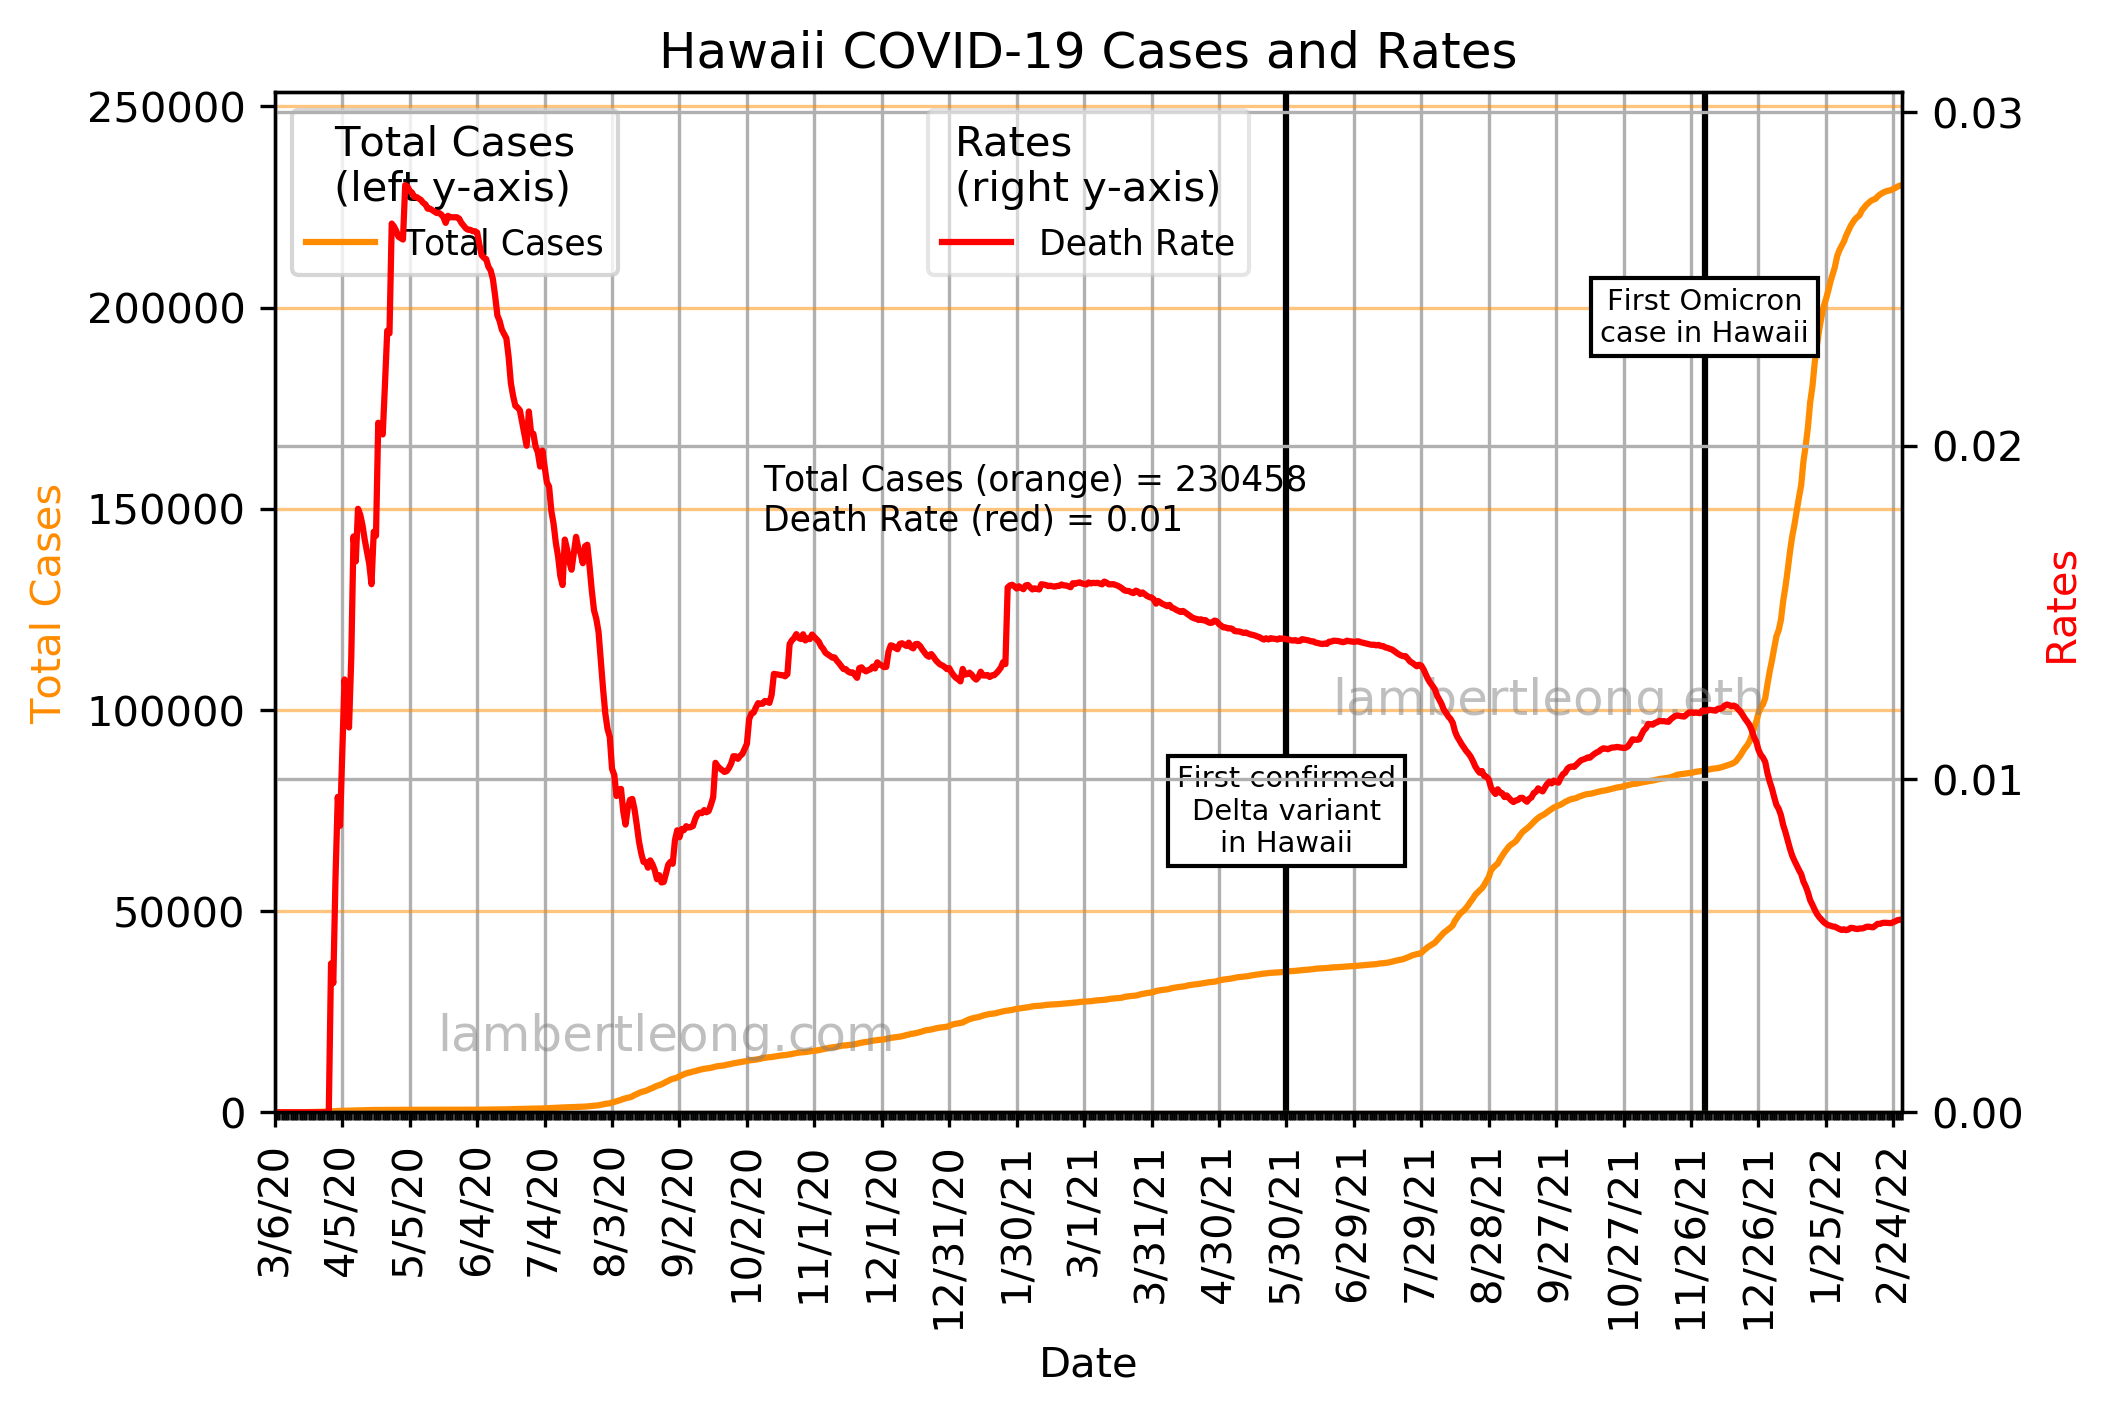

In [21]:
dates,t,d=d3['Date'],d3['cases'],d3['death_rate']
ymax1=None
ymax2=None
chart=plot_caseVdeath(d3)
chart#.savefig('full_caseVdeath_covid.png', dpi=300, bbox_inches='tight')

In [22]:
### Build Animation ###
'''
ysize, xsize = 5.25,7
start = time.time()
writer = imageio.get_writer('nytimes_data_caseVdeath.mp4', fps=15)
for i in range(1,d3.shape[0]):
    #if i>100:#365:
    #    break
    start2 = time.time()
    sub_df=d3.iloc[:i]
    chart=plot_caseVdeath(sub_df,xsize=xsize,ysize=ysize)
    dpi=int(chart.dpi)
    chart.canvas.draw()
    image = np.frombuffer(chart.canvas.tostring_rgb(), dtype='uint8').reshape(int(ysize*dpi), int(xsize*dpi), 3)
    writer.append_data(image)   
    end2 = time.time()
    print('processed =',i,'time =',end2-start2,end='\r')
writer.close()
end = time.time()
print('nytimes plot build time =',end - start)
'''


"\nysize, xsize = 5.25,7\nstart = time.time()\nwriter = imageio.get_writer('nytimes_data_caseVdeath.mp4', fps=15)\nfor i in range(1,d3.shape[0]):\n    #if i>100:#365:\n    #    break\n    start2 = time.time()\n    sub_df=d3.iloc[:i]\n    chart=plot_caseVdeath(sub_df,xsize=xsize,ysize=ysize)\n    dpi=int(chart.dpi)\n    chart.canvas.draw()\n    image = np.frombuffer(chart.canvas.tostring_rgb(), dtype='uint8').reshape(int(ysize*dpi), int(xsize*dpi), 3)\n    writer.append_data(image)   \n    end2 = time.time()\n    print('processed =',i,'time =',end2-start2,end='\r')\nwriter.close()\nend = time.time()\nprint('nytimes plot build time =',end - start)\n"

In [23]:
sys.exit(0)

SystemExit: 0

/mnt/srl-oahu-1/disk/lambert/anaconda/envs/env_jun21/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# Please site and check out lambertleong.com
# Donate at lambertleong.eth
# follow @leonglambert